In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import celerite as ce
import emcee as mc
import QPP_Funcs as qpp
import corner
import astropy
import os
from scipy import signal
from celerite.modeling import Model
from scipy.optimize import minimize, curve_fit
import h5py

i=0
plots = []
corners = []
datadir = "/Users/chris/Documents/QPP/SolarFlareGPs/data/daniela_goes_data/"

#for burstid in range(1520110128,1520170715):
while (i<1):
    burstid = np.random.randint(1520110128,1520170715) #1520111001 
    try:
        time, flux, header = qpp.load_data(datadir,burstid, returnhead=True)
    except(IOError):
        pass
    else:
        time, flux = qpp.load_data(datadir,burstid)
        i+=1
        tt,ft = qpp.trim_data(time,flux)
        ft = ft*1e10  #cheating conversions!!!
        ft_err = np.sqrt(ft)
        print("Lightcurve " + str(i) + ", burstid: " + str(burstid))


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Lightcurve 1, burstid: 1520140507


Initializing...
Initial log-parameters:[ 0.          0.          0.          0.          0.         11.83359528
  6.70781445  7.40096163]


QPP_Funcs.py:27: RuntimeWarning: divide by zero encountered in divide
  return A*lam*np.exp((-tau1/t)-(t/tau2))


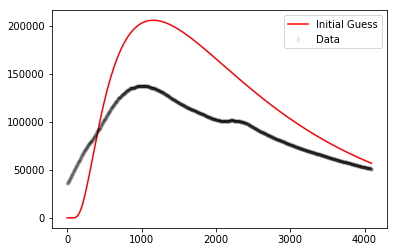

In [2]:
#initialization block
print("Initializing...")

A_guess, t1_guess, t2_guess = qpp.initguess(tt,ft)
model = qpp.CTSModel_prior(log_A = np.log(A_guess), log_tau1 = np.log(t1_guess), log_tau2 = np.log(t2_guess))
kernel1 = qpp.SHOTerm_Prior(log_S0 = 0, log_Q = 0, log_omega0 = 0) #write guesser for kernel parameters
kernel2 = qpp.RealTerm_Prior(log_a=0., log_c=0.) #write guesser for kernel parameters
kernel = kernel2 + kernel1
gp = ce.GP(kernel, mean=model, fit_mean=True)
gp.compute(tt, ft_err)
figinit = qpp.plot_gp(tt,ft, ft_err, gp, model, predict=True, label="Initial Guess")
initparams = gp.get_parameter_vector()
print("Initial log-parameters:" + str(initparams))
plt.show()

Optimizing...
Initial log-likelihood: -21545289.0043
Final log-likelihood: -1401462.90889
Optimized log-parameters: [ 4.62953043e-05 -2.49170210e-05  3.56456149e-05  4.30322925e-07
  3.99918665e-06  1.08503153e+01  5.47159406e+00  8.01550767e+00]


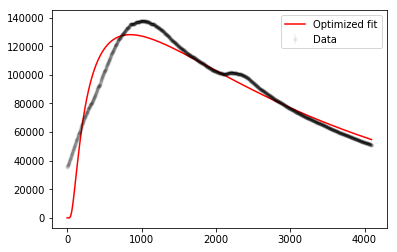

In [3]:
print("Optimizing...")

#optimization
soln = qpp.optimize_gp(gp, ft)
gp.set_parameter_vector(soln.x)
figopt = qpp.plot_gp(tt, ft, ft_err, gp, model, predict=True, label = "Optimized fit")
#plt.show()


In [4]:

#sampling
sampler = qpp.sample_gp(initparams, ft, gp, burnin=100, nwalkers=100, nsteps = 500)
chain = sampler.chain

Burning in...


QPP_Funcs.py:71: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_S0*prob_Q*prob_omega0 * np.e)


Sampling...


QPP_Funcs.py:53: RuntimeWarning: divide by zero encountered in log
  return np.log(probA * probtau1 * probtau2 * np.e)
QPP_Funcs.py:86: RuntimeWarning: divide by zero encountered in log
  return np.log(prob_a*prob_c * np.e)


Done!


In [5]:
'''
trimratio = 0.5
trimchain = chain[:,int(trimratio * len(chain[0])):,:]

print("Plotting time series...")
figsam = qpp.plot_chain(chain, labels = gp.get_parameter_names())

print("Plotting posterior predictions...")
figoptsam = qpp.plot_gp(tt, ft, ft_err, gp, model, chain=chain)

print("Plotting corner plot...")
figcorner, maxparams = qpp.plot_corner(chain, labels = gp.get_parameter_names())
print "Max logparams:"
print maxparams
print "Max params:"
print np.e**maxparams
plt.show()
'''

'\ntrimratio = 0.5\ntrimchain = chain[:,int(trimratio * len(chain[0])):,:]\n\nprint("Plotting time series...")\nfigsam = qpp.plot_chain(chain, labels = gp.get_parameter_names())\n\nprint("Plotting posterior predictions...")\nfigoptsam = qpp.plot_gp(tt, ft, ft_err, gp, model, chain=chain)\n\nprint("Plotting corner plot...")\nfigcorner, maxparams = qpp.plot_corner(chain, labels = gp.get_parameter_names())\nprint "Max logparams:"\nprint maxparams\nprint "Max params:"\nprint np.e**maxparams\nplt.show()\n'

In [6]:
%load_ext autoreload
%autoreload
import QPP_Funcs as qpp

In [7]:
#Testing out HDF5 for storing data
import os
fname = "Data/Test/burst_" + str(burstid) +"/"
if not os.path.exists(fname):
    os.makedirs(fname)
qpp.store_flare(fname+"data", header, tt, ft, soln.x, chain)




Stored flare at Data/Test/burst_1520140507/data


In [8]:
head_load, t_load, I_load, optparams_load, chain_load = qpp.load_flare(fname+"/data", astroheader==True)
head_load
textheader = open(fname+"header.txt",'w')
head_load.tofile(textheader)
textheader.close()


Plotting time series...
Plotting posterior predictions...
Plotting corner plot...
Max logparams:
[-0.1309402  -1.46485842  0.11277235  0.47007066  0.29424597 10.83717165
  5.50257726  8.01998046]
Max params:
[8.77270237e-01 2.31110709e-01 1.11937708e+00 1.60010725e+00
 1.34211398e+00 5.08772757e+04 2.45323380e+02 3.04111790e+03]


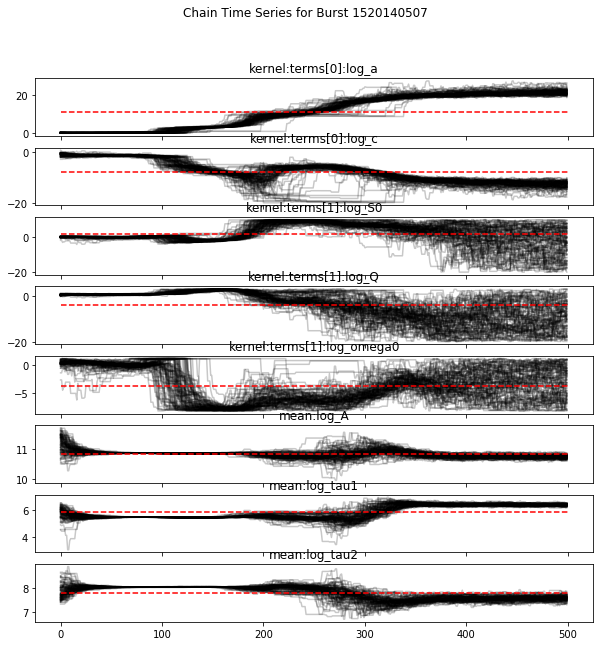

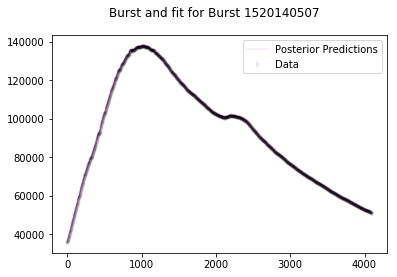

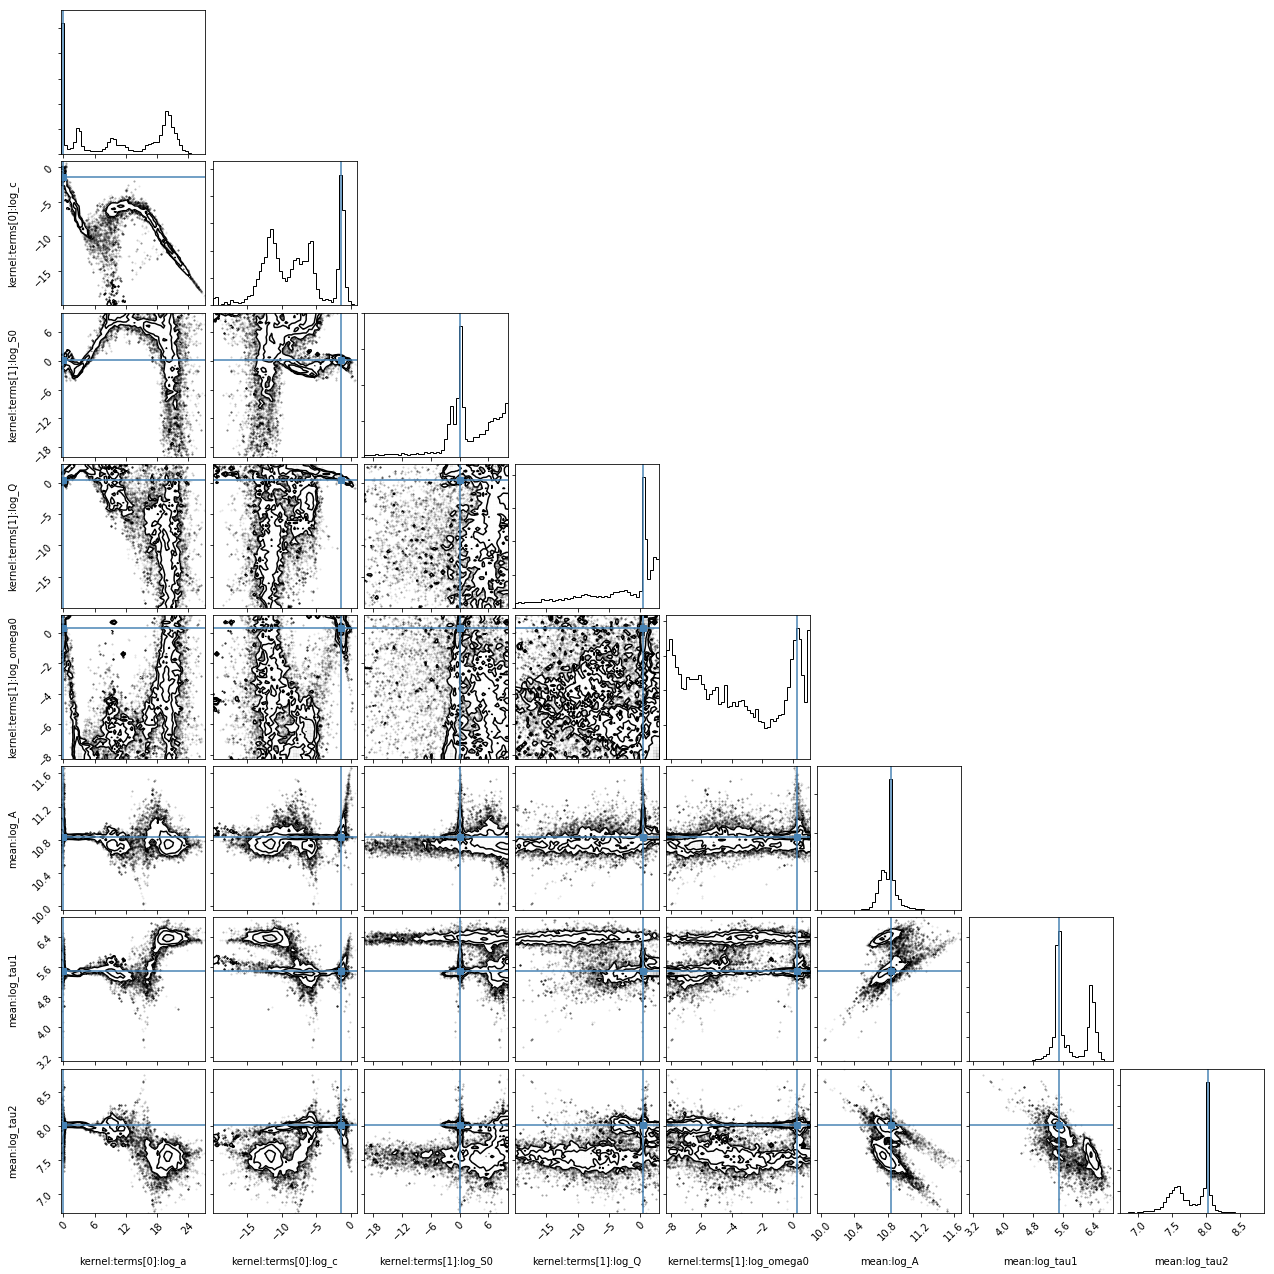

In [15]:

print("Plotting time series...")
figsam_load = qpp.plot_chain(chain_load, labels = gp.get_parameter_names(), burstid=burstid)
figsam_load.savefig(fname+"chain_ts.png")
print("Plotting posterior predictions...")
figoptsam_load = qpp.plot_gp(t_load, I_load, np.sqrt(I_load), gp, model, chain=chain_load, burstid=burstid)
figoptsam_load.savefig(fname+"lc_plot.png")
print("Plotting corner plot...")
figcorner_load, maxparams_load = qpp.plot_corner(chain_load, labels = gp.get_parameter_names(), burstid=burstid)
figcorner_load.savefig(fname+"chain_corner.png")



print "Max logparams:"
print maxparams_load
print "Max params:"
print np.e**maxparams_load
plt.show()

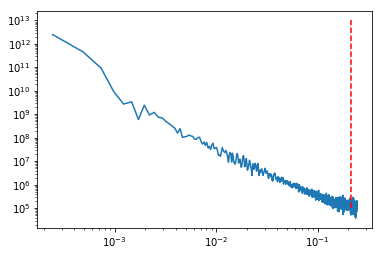

In [14]:
f_0 = ((np.exp(maxparams_load[4]))/ (2*np.pi))  * np.ones(100) 
yline = np.logspace(5,13,100)
fig = plt.figure()
freq, power = sp.signal.periodogram(I_load, fs = (1./(t_load[1]-t_load[0])))
plt.loglog(freq[1:], power[1:])
plt.plot(f_0, yline, 'r--')
plt.show()